In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import math

%matplotlib inline

In [30]:
def find_points(img):
    diff = np.max(img) - np.min(img)
    return np.argwhere(img > diff/4)

def display_results(h_recovered, v_recovered, print_points=False):
    num_samples = np.shape(v_recovered)[0]
    nrows = ncols = math.ceil(np.sqrt(num_samples))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
    for i in range(num_samples):
        axes[i // nrows, i % nrows].imshow(np.real(v_recovered[i]), cmap='gray')
        axes[i // nrows, i % nrows].title.set_text('v_recovered ' + str(i))
        if print_points:
            print(find_points(v_recovered[i]))
        
    '''
    for i in range(len(v_recovered)):
        plt.figure()
        plt.imshow(np.real(v_recovered[i]), cmap='gray')
        plt.title('v_recovered ' + str(i))
        print(find_points(v_recovered[i]))
    '''
    
    plt.figure()
    plt.imshow(np.real(h_recovered), cmap='gray')
    plt.title('h_recovered')
    if print_points:
        print(find_points(h_recovered))
        
def initMatrices(dim, num):
    # Initial guesses for h and vi
    h = np.ones((dim, dim))
    v = np.ones((num, dim, dim))
    # normalize them
    h = h / np.linalg.norm(h)
    v = v / np.linalg.norm(v)
    return h, v

In [31]:
# sgn(xi)max(0,|xi|−τ)
def calc_soft_thresh(x, tau):
    # numpy automatically applies functions to each element of the array
    return np.sign(x)*np.maximum(0, np.abs(x) - tau)

# Now vk is a 3 dimensional array, H is still 2D
def calcA_v(H, vk):
    H3 = np.tile(H, (np.shape(vk)[0], 1, 1))
    Vk = fft.fft2(fft.ifftshift(vk, axes = (1, 2)))
    return fft.fftshift(fft.ifft2(H3*Vk), axes = (1, 2))

def calcAHerm_v(Hadj, diff):
    xpad = diff
    X = fft.fft2(fft.ifftshift(xpad, axes = (1, 2)))
    return fft.fftshift(fft.ifft2(Hadj*X), axes = (1, 2))

def calcA_h(V, h):
    H = fft.fft2(fft.ifftshift(h))
    H3 = np.tile(H, (np.shape(V)[0], 1, 1))
    return fft.fftshift(fft.ifft2(H3*V), axes = (1, 2))

def calcAHerm_h(Vadj, diff):
    xpad = diff
    X = fft.fft2(fft.ifftshift(xpad, axes = (1, 2)))
    return np.sum(fft.fftshift(fft.ifft2(Vadj*X), axes = (1, 2)), axis = 0)


In [32]:
def calc_loss_h(H, v, b):
    return calcA_v(H, v) - b
    
def calc_loss_v(V, h, b):
    return calcA_h(V, h) - b

def calc_sum_sq(v):
    return np.abs(np.sum(v**2))
    
def gd_update(iterations, alpha_v, alpha_h, b, h, v, mode):
    if mode == "v":
        _, v = initMatrices(800, 4)
    elif mode == "h":
        h, _ = initMatrices(800, 4)
    elif mode == "both":
        h, v = initMatrices(800, 4)
    else:
        print('invalid mode')
        return
    
    V = fft.fft2(fft.ifftshift(v, axes = (1, 2)))
    Vadj = np.conj(V)
    
    for i in range(iterations):
        if i % 10 == 0 and i != 0:
            print(str(i) + "th iteration")
            if mode == "v" or mode == "both":
                print('loss_v: ' + '{:.2e}'.format(calc_sum_sq(loss_v)))
            if mode == "h" or mode == "both":
                print('loss_h: ' + '{:.2e}'.format(calc_sum_sq(loss_h)))
            if i % 20 == 0:
                display_results(h, v)
            
        # derivative w.r.t. v
        if mode == "v" or mode == "both":
            H = fft.fft2(fft.ifftshift(h))
            Hadj = np.conj(H)
            loss_v = calc_loss_h(H, v, b)
            v = v - alpha_v * np.real(calcAHerm_v(Hadj, loss_v))
            v = np.maximum(v, 0)
        # derivative w.r.t. h
        if mode == "h" or mode == "both":
            V = fft.fft2(fft.ifftshift(v, axes = (1, 2)))
            Vadj = np.conj(V)
            loss_h = calc_loss_v(V, h, b)
            h = h - alpha_h * np.real(calcAHerm_h(Vadj, loss_h))
            h = np.maximum(h, 0)
        
    return h, v

def generate_single_b(h, v = None, num_points = 5):
    # generate light source with num_points
    if np.any(v) == None:
        v = np.zeros((800,800))
        points = np.random.randint(low=0, high=800, size=(num_points,2))
        # print(points)
        for point in points:
            v[tuple(point)] = 1

    # convolve light source with psf
    h_pad = np.pad(h, 400, mode='constant')
    v_pad = np.pad(v, 400, mode='constant')

    H_PAD = np.fft.fft2(np.fft.ifftshift(h_pad))
    V_PAD = np.fft.fft2(np.fft.ifftshift(v_pad))
    B = H_PAD * V_PAD

    b = np.fft.fftshift(np.fft.ifft2(B))
    b = np.abs(b)[400:1200, 400:1200]
    
    return b

def generate_b(h, vs = None, num_samples = 4, num_points = 5):
    b = np.empty((num_samples, h.shape[0], h.shape[1]))
    for i in range(num_samples):
        b[i] = generate_single_b(h, num_points=num_points) if np.all(vs) == None else generate_single_b(h, vs[i], num_points)
    return b



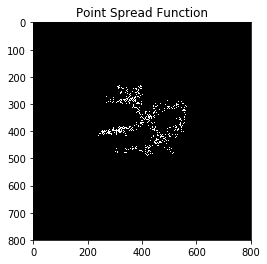

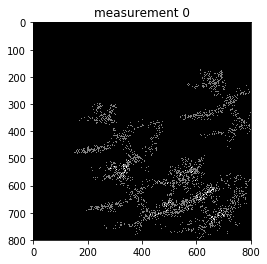

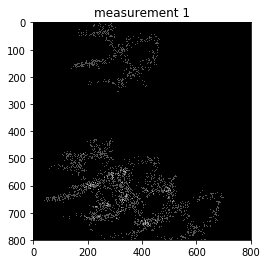

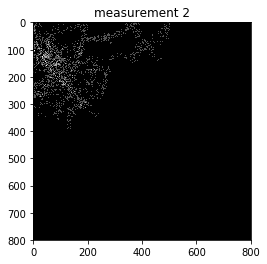

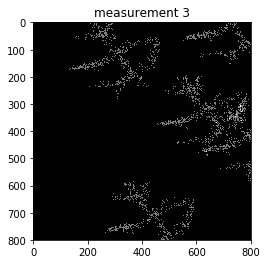

In [33]:
# Define h and v's here
h = np.asarray(Image.open('psf.png').convert('L'))
h = np.pad(h, 200, mode='constant')

# now we normalize h
h = h / np.linalg.norm(h)
plt.figure()
plt.imshow(h, cmap = 'gray')
plt.title('Point Spread Function')

# setting the points that we will end up convolving with the psf to get b
points_array = np.array([
    [[343, 702],
     [679, 359],
     [699, 592],
     [469, 308],
     [665, 631]],
    [[601, 292],
     [732, 528],
     [717, 347],
     [645, 198],
     [154, 301]],
    [[266, 114],
     [182,  16],
     [113,  32],
     [235,  74],
     [ 59, 345]],
    [[756, 426],
     [463, 776],
     [367, 621],
     [ 51, 712],
     [162, 296]]
])

vs = np.zeros((4,800,800))

for i in range(len(points_array)):
    points = points_array[i]
    for point in points:
        vs[i][tuple(point)] = 1

# normalize the vs (entire 3D array)
vs = vs / np.linalg.norm(vs)

# convolve h with each of the 2D v's
b = generate_b(h, vs)

for i in range(4):
    plt.figure()
    plt.title('measurement ' + str(i))
    _ = plt.imshow(b[i], cmap='gray')

alpha: 0.0002608695652173913
10th iteration
loss_v: 9.19e-01
loss_h: 9.19e-01
20th iteration
loss_v: 9.19e-01
loss_h: 9.19e-01
30th iteration
loss_v: 9.19e-01
loss_h: 9.19e-01
40th iteration
loss_v: 9.19e-01
loss_h: 9.19e-01


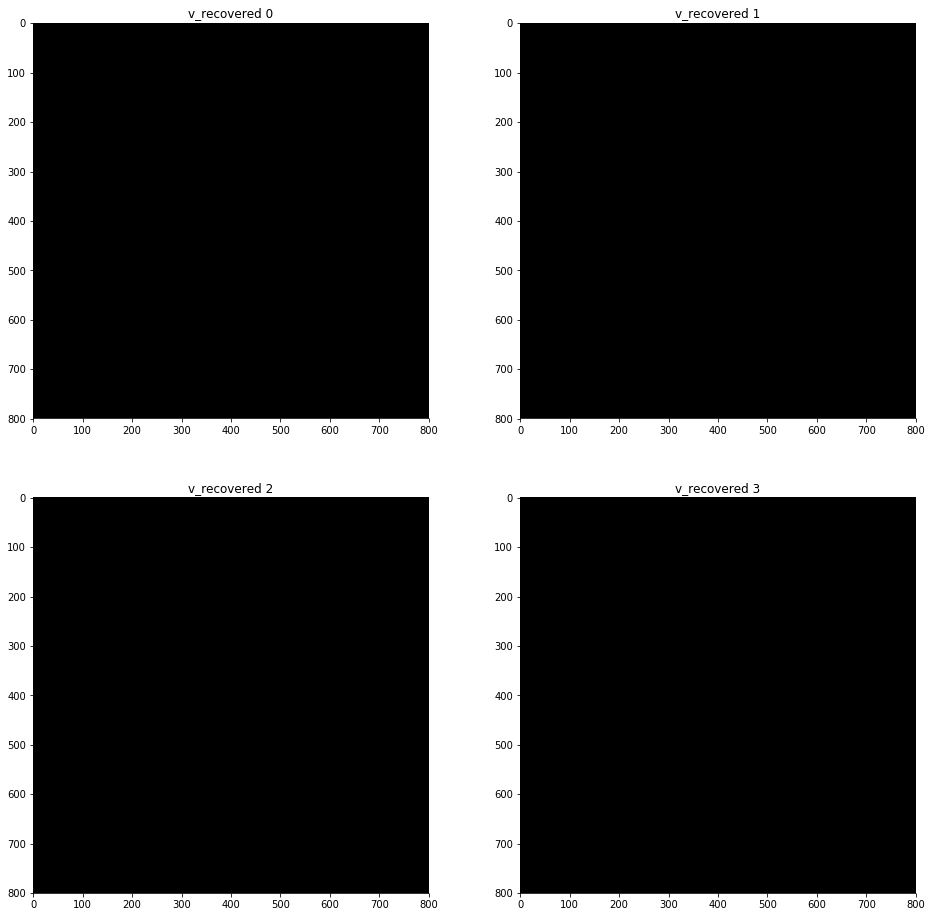

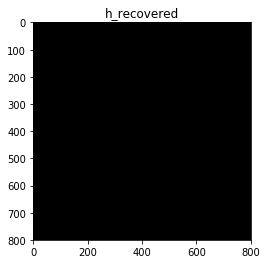

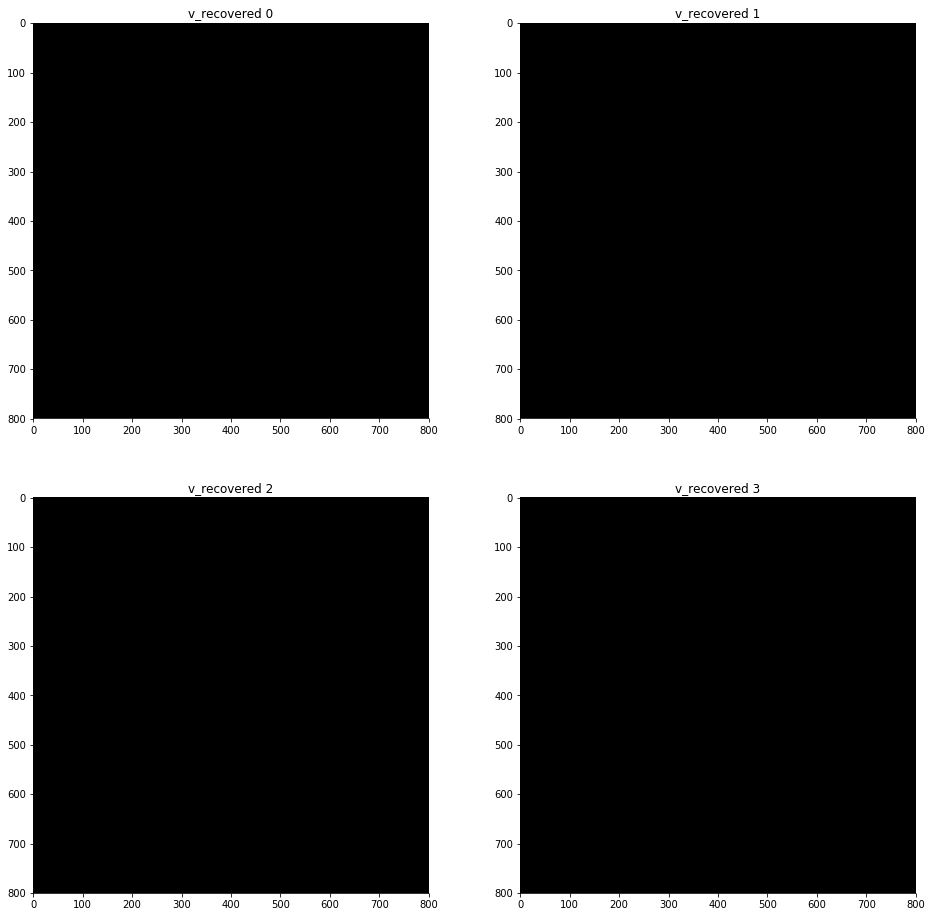

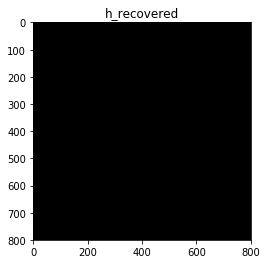

In [34]:
H = fft.fft2(fft.ifftshift(h))
Hadj = np.conj(H)
alpha = np.real(1.8 / np.max(Hadj * H))
# print('alpha: ' + str(alpha))
# alpha_v = 1e-12
# alpha_h = 1e-3
# alpha_v = 1e-3
# alpha_h = 1e-1
alpha_v = 1e-6
alpha_h = 1e-3

# run with "h", "v", or "both", displays h and vs every 20 iterations
h_recovered, v_recovered = gd_update(50, alpha_v, alpha_h, b, h, vs, "both")

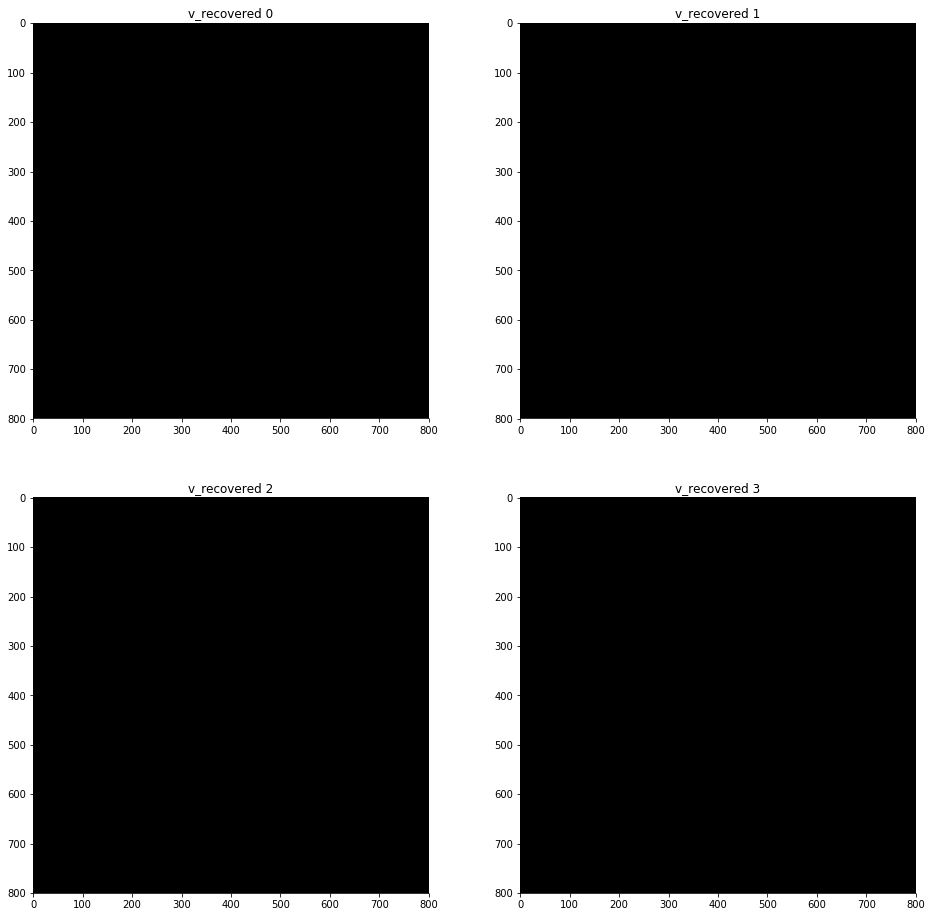

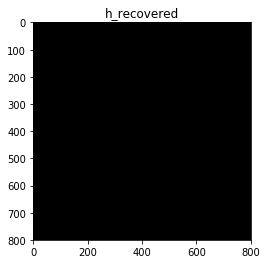

In [35]:
# display final result
display_results(h_recovered, v_recovered)